In [11]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
%matplotlib inline

C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30
Mpc = 3.086*1e22

duration = 36.
sampling_frequency = 1024.

outdir = 'outdir'
label = 'GW200105'
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.
np.random.seed(150914)

In [29]:
# time length of
mass_1 = 1.0
mass_2 = 1.0
chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
mass_ratio = mass_2/mass_1
ff = (C**3)/( G*(mass_1+mass_2)*Mo*np.pi*6**(3/2) )
tot_m = chirp_mass*(1+mass_ratio)**(6/5)/mass_ratio**(3/5)
print(chirp_mass,mass_ratio)
print(ff)
print(tot_m)

0.8705505632961241 1.0
2198.0075184694997
1.9999999999999998


In [19]:
# GW170817
= 1187008882.4

In [17]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")
V1 = bilby.gw.detector.get_empty_interferometer("V1")

In [18]:
post_trigger_duration = 2
duration = 36
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=1024, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=1024, cache=True)

V1_analysis_data = TimeSeries.fetch_open_data(
    "V1", analysis_start, analysis_start + duration, sample_rate=1024, cache=True)

ValueError: Cannot find a GWOSC dataset for H1 covering [1187008848, 1187008885)

In [22]:
post_trigger_duration = 2
duration = 36
analysis_start = time_of_event + post_trigger_duration - duration

waveform_arguments = dict(waveform_approximant='OSMFD',
                          reference_frequency=10., minimum_frequency=10.)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_eccentric_advancement_of_pariastron,
    waveform_arguments=waveform_arguments)

05:55 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_eccentric_advancement_of_pariastron
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [23]:
ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=analysis_start)

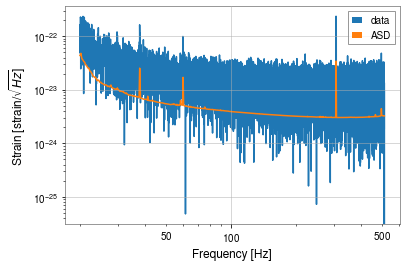

In [24]:
H1 = ifos[0]

fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]),
          label="data")
ax.loglog(H1.frequency_array[idxs],
          H1.amplitude_spectral_density_array[idxs],
          label="ASD")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax.legend()
plt.show()

In [ ]:
'''(mass_1=13.5, mass_2=11.5, luminosity_distance=40.0.,
    theta_jn=0.4, psi=0.1, phase=1.2, geocent_time=1180002601.0, ra=45, dec=5.73)'''

prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass', minimum=0.8705505632961241,maximum=4.35275281648062)
prior['mass_ratio'] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.1, maximum=1)
prior['eccentricity'] = bilby.core.prior.LogUniform(name='initial_eccentricity', minimum=0.01, maximum=0.2),
prior["luminosity_distance"] = bilby.gw.prior.UniformComovingVolume(name='luminosity_distance', minimum=10.0, maximum=500.0, unit='Mpc'),
prior["theta_jn"] = 0.4
prior["psi"] = 0.1
prior["phase"] = 1.2
prior["geocent_time"] = 1180002601.0

prior["ra"] = 45.0
prior["dec"] = 5.73

#this is to run the code faster
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator, priors=prior)

In [ ]:
result_short = bilby.core.sampler.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="eccn",
    nlive=500, dlogz=3.0, npool=8 )